# The Most Dangerous State

CSPB 3287 Semester Project \
Name: Benjamin Price \
Identikey: bepr7452 \
Email: benjamin.price@colorado.edu

# Proposal Summary

I propose to use information from the US Census, the National Highway Traffic Safety Administration, and the Murder Accountability Project to build a database.  The goal will be to utilize JOINS among the different relations in order to determine any correlations between a given state, its homicide rate, and its fatal traffic accident rates.  In this way, I should be able to view growing or shrinking trends over time by state for types of non-medical-related mortality, but also view comprehensive information about which states were the most dangerous of them all between 2010 and 2019!

Based on the data I have retrieved, the user will be able to pull data based on any number of filters, such as reporting agency using an attribute such as ORI ( Originating Agency ), state, year, etc.  Additionally, population information can be taken into account, including total deaths in a given year, total populations in a state over a series of years between 2010 and 2019, etc.  Finally, additional data will be able to be added or deleted without interfering with the provided constraints in the relations by way of triggers.  If something cannot be deleted, an error will be reported to the user with the reason. 

The data will be stored using MySQL on Google Cloud Platform because I would like to become more familiar with database hosting platforms and a team member in another class said it worked pretty well.  This specific platform will help me learn to query a database over the internet which will allow portability for my project.  I will author a JupyterLab notebook in order to create scripts that query the data to show the possible relationships between the different relations.  This project will help me learn how to link multiple disparate data sets and draw conclusions that no single data set would be able to answer alone.  Fingers crossed that Colorado isn’t the most dangerous state!

SQL Interface: SQL Alchemy with a MySQL Database.  This was the interface that I used in lab 4 to connect to a MySQL database on the Google Cloud platform and it seemed to work really well.  SQL Alchemy will allow python functionality to assist in performing the usual SQL queries, which will be useful when having to insert multiple rows into a table of data that is randomly generated at runtime.  The full explanation of SQL Alchemy features can be found here: https://www.sqlalchemy.org/features.html

## Tools

- Google Cloud Platform as a host: This will provide global access to the database so the project can be accessed from any user with the appropriate passwords and permissions.
- MySQL Database
- MySQL Workbench to create a diagram of table relations
- Python Notebook crafted to demonstrate project features (in lieu of an online user interface)
- SqlAlchemy to connect to and update database (mysqlclient and mysql-connector-python modules)
- Python libraries Numpy and Pandas for preemptive data cleaning

## Data

- Murders By Year/State (UCR - Uniform Crime Report) & Individual Murder Cases (SHR - Supplemental Homicide Report): http://www.murderdata.org/p/data-docs.html
- Census Population Data 2010 - 2019 (NST-EST2019-alldata) https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
- Fatality and Injury Reporting System Tool (FIRST) https://cdan.dot.gov/query

# Data Cleaning

The data in its Raw form was not ideal for the project.
A separate Python notebook utilizing the Pandas and Numpy Python libraries was used to clean the .csv datasets.  In particular, columns that were not necessary for the project were removed, as well as any columns with too many NaN or null values.  For example, the individual murder data contained both a State and a StateName table, where StateName was always NaN.  The StateName column was safely removed with the real state data preserved in the State column.  While this cleaning could have been done by just ommitting these columns during SQL insert queries, it was much easier to view and understand the data through this cleaning process.

Additionally, during the initial creation of the database, there were some issues with the size of the data being added to the database.
To address this, a second round of data cleaning was done in a separate Python notebook.  A new .csv file was created by taking a random sampling of 5000 entries from the individual murder data (the previous data had over 160,000 entries).  The decision was made to forego using any separate total murder data and instead we would create the total murder table in the database by incrementing entries using triggers when adding the entries to the IndividualMurders table.

# Database Creation

The mysqlclient and mysql-connector-python modules were installed and sqlalchemy was used as the interface to connect and interact with the database hosted on the Google Cloud.  First the basic Tables were created with carefully selected datatypes.  This constrains the types of values that can be added, as well as constrains the length of string data for a given attribute.  For instance, the 'ori' column in the ORIs table is a VARCHAR(7) because an ORI does not exceed seven characters.  Additionally, default values and NULL allowances were added where appropriate and PRIMARY keys were chosen for each table.  Finally, foreign key constraints were also added where appropriate.  For example, the foreign key on the 'state' column in ORIs references the state value in the States table, so that only an actual state in the United States can be used. Foreign keys were set to CASCADE on updates, to prevent any discrepancies with old data in the tables, and were set to RESTRICT on deletes to ensure that foreign keys are kept intact. Please see below the code used to create the tables according to the diagram.

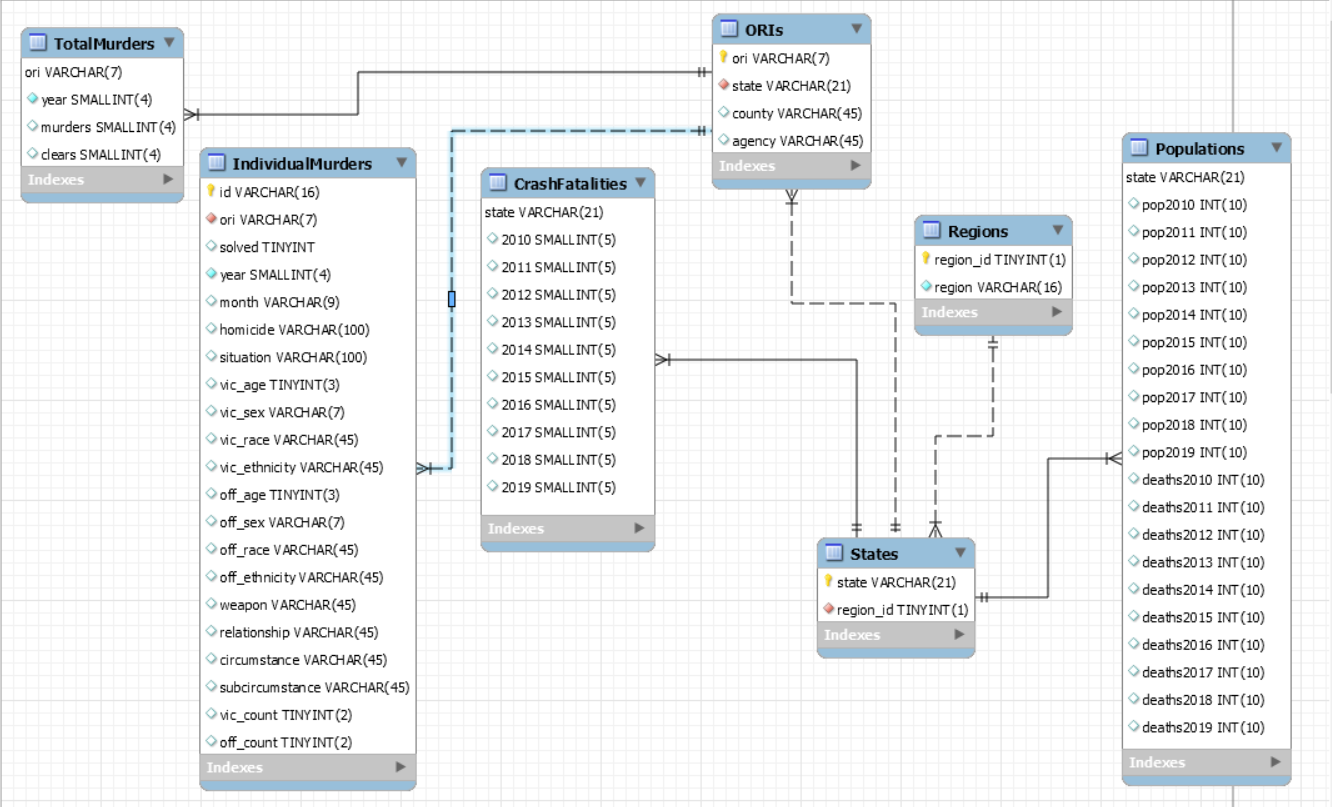

In [7]:
from IPython.display import Image
Image(filename='Model/EER_Diagram.png') 

## Table Creation

In [1]:
# import statements
import subprocess
import sqlalchemy
from sqlalchemy import text
import csv

In [2]:
# Need to reinstall mysql through terminal
subprocess.run(["pip","install","mysqlclient"])
subprocess.run(["pip","install","mysql-connector-python"])

CompletedProcess(args=['pip', 'install', 'mysql-connector-python'], returncode=0)

In [3]:
# Create Database URI for connection
USER = "root"
PASSWORD = "secretsmakefriends125678"
PUBLIC_IP_ADDRESS ="34.105.17.205"
DBNAME ="mostDangerousState_db"

DATABASE_URI=f'mysql+mysqlconnector://{USER}:{PASSWORD}@{PUBLIC_IP_ADDRESS}/{DBNAME}'

In [4]:
# Connect to Database
try:
    engine = sqlalchemy.create_engine( DATABASE_URI )
    conn = engine.connect()
except Exception as exp:
    print("Create engine failed:", exp)

In [ ]:
# Drop all existing Tables
# The order here matters because of 
# restricted DELETE constraints on foreign keys
conn.execute("DROP TABLE IF EXISTS TotalMurders;")
conn.execute("DROP TABLE IF EXISTS IndividualMurders;")
conn.execute("DROP TABLE IF EXISTS ORIs;")
conn.execute("DROP TABLE IF EXISTS CrashFatalities;")
conn.execute("DROP TABLE IF EXISTS Populations;")
conn.execute("DROP TABLE IF EXISTS States;")
conn.execute("DROP TABLE IF EXISTS Regions;")
conn.execute("SHOW TABLES;").fetchall()

In [ ]:
# Regions Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS Regions (
        id TINYINT(1) NOT NULL,
        region VARCHAR(16) NOT NULL,
        PRIMARY KEY (id));
""")

In [ ]:
# States Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS States (
        state VARCHAR(21) NOT NULL,
        region_id TINYINT(1) NOT NULL,
        PRIMARY KEY (state),
        CONSTRAINT fk_region_id
            FOREIGN KEY (region_id)
            REFERENCES Regions (id)
            ON DELETE RESTRICT
            ON UPDATE CASCADE);
""")

In [ ]:
# ORIs Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS ORIs (
        ori VARCHAR(7) NOT NULL,
        state VARCHAR(21) NOT NULL,
        county VARCHAR(45) NULL,
        agency VARCHAR(45) NULL,
        PRIMARY KEY (ori),
        FOREIGN KEY (state)
            REFERENCES States (state)
            ON DELETE RESTRICT
            ON UPDATE CASCADE);
""")

In [ ]:
# Populations Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS Populations (
        state VARCHAR(21) NOT NULL,
        pop2010 INT(10) UNSIGNED NULL,
        pop2011 INT(10) UNSIGNED NULL,
        pop2012 INT(10) UNSIGNED NULL,
        pop2013 INT(10) UNSIGNED NULL,
        pop2014 INT(10) UNSIGNED NULL,
        pop2015 INT(10) UNSIGNED NULL,
        pop2016 INT(10) UNSIGNED NULL,
        pop2017 INT(10) UNSIGNED NULL,
        pop2018 INT(10) UNSIGNED NULL,
        pop2019 INT(10) UNSIGNED NULL,
        deaths2010 INT(10) UNSIGNED NULL,
        deaths2011 INT(10) UNSIGNED NULL,
        deaths2012 INT(10) UNSIGNED NULL,
        deaths2013 INT(10) UNSIGNED NULL,
        deaths2014 INT(10) UNSIGNED NULL,
        deaths2015 INT(10) UNSIGNED NULL,
        deaths2016 INT(10) UNSIGNED NULL,
        deaths2017 INT(10) UNSIGNED NULL,
        deaths2018 INT(10) UNSIGNED NULL,
        deaths2019 INT(10) UNSIGNED NULL,
        PRIMARY KEY (state),
        FOREIGN KEY (state)
            REFERENCES States (state)
            ON DELETE RESTRICT
            ON UPDATE CASCADE);
        
""")

In [ ]:
# CrashFatalities Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS CrashFatalities (
        state VARCHAR(21) NOT NULL,
        year2010 SMALLINT(5) UNSIGNED NULL,
        year2011 SMALLINT(5) UNSIGNED NULL,
        year2012 SMALLINT(5) UNSIGNED NULL,
        year2013 SMALLINT(5) UNSIGNED NULL,
        year2014 SMALLINT(5) UNSIGNED NULL,
        year2015 SMALLINT(5) UNSIGNED NULL,
        year2016 SMALLINT(5) UNSIGNED NULL,
        year2017 SMALLINT(5) UNSIGNED NULL,
        year2018 SMALLINT(5) UNSIGNED NULL,
        year2019 SMALLINT(5) UNSIGNED NULL,
        PRIMARY KEY (state),
        FOREIGN KEY (state)
            REFERENCES States (state)
            ON DELETE RESTRICT
            ON UPDATE CASCADE);
""")

In [ ]:
# TotalMurders Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS TotalMurders (
        ori VARCHAR(7) NOT NULL,
        year SMALLINT(4) NOT NULL,
        murders SMALLINT(4) NULL,
        clears SMALLINT(4) NULL,
        PRIMARY KEY (ori, year),
        FOREIGN KEY (ori)
            REFERENCES ORIs (ori)
            ON DELETE RESTRICT
            ON UPDATE CASCADE);
""")

In [ ]:
# IndividualMurders Table
conn.execute("""
    CREATE TABLE IF NOT EXISTS IndividualMurders (
        id VARCHAR(16) NOT NULL,
        ori VARCHAR(7) NOT NULL,
        solved TINYINT NULL DEFAULT 0,
        year SMALLINT(4) NOT NULL,
        month VARCHAR(9) NULL,
        homicide VARCHAR(100) NULL,
        situation VARCHAR(100) NULL,
        vic_age TINYINT(3) NULL,
        vic_sex VARCHAR(7) NULL,
        vic_race VARCHAR(45) NULL,
        vic_ethnicity VARCHAR(45) NULL,
        off_age TINYINT(3) NULL,
        off_sex VARCHAR(7) NULL,
        off_race VARCHAR(45) NULL,
        off_ethnicity VARCHAR(45) NULL,
        weapon VARCHAR(45) NULL,
        relationship VARCHAR(45) NULL,
        circumstance VARCHAR(45) NULL,
        subcircumstance VARCHAR(45) NULL,
        vic_count TINYINT(2) NULL,
        off_count TINYINT(2) NULL,
        PRIMARY KEY (id),
        FOREIGN KEY (ori)
            REFERENCES ORIs (ori)
            ON DELETE RESTRICT
            ON UPDATE CASCADE);
""")

In [5]:
# Confirm Tables exist
conn.execute("SHOW TABLES;").fetchall()

[('CrashFatalities',),
 ('IndividualMurders',),
 ('ORIs',),
 ('Populations',),
 ('Regions',),
 ('States',),
 ('TotalMurders',)]

## Triggers

Triggers were added next.  It was important to create triggers for when the IndividualMurders table was updated to make sure the TotalMurders table stayed up-to-date.  We needed to ensure that when a an entry was added, the correct total in TotalMurders was incremented and when an entry was deleted, that the corresponding TotalMurders entry was decremented.  This would also be leveraged to forego using any explicit data to manually create the TotalMurders table and instead to have the table be automatically created as we created the IndividualMurders table.  In particular, it was important to make careful note of the edge cases when the first murder is entered for a specific year and ORI (Originating Agency Identifier) and when a sole remaining murder for a specific ORI and year is deleted.  In these cases, an entire entry in the TotalMurders table will be created or deleted to maintain that there are only entries in the TotalMurders table if there is at least one entry with the same ORI and year in the IndividualMurders table.

In [ ]:
# ins_murd Trigger
# updates TotalMurders table when an entry
# is added to IndividualMurders
conn.execute("DROP TRIGGER IF EXISTS ins_murd")
conn.execute("""
    CREATE TRIGGER ins_murd 
    AFTER INSERT ON IndividualMurders
    FOR EACH ROW
    BEGIN
        IF EXISTS (SELECT * FROM TotalMurders WHERE ori=NEW.ori AND year=NEW.year) THEN
            UPDATE TotalMurders
            SET murders = murders + 1, clears = clears + NEW.solved
            WHERE ori = NEW.ori AND year = NEW.year;
        ELSE
            INSERT INTO TotalMurders
            VALUES (NEW.ori, NEW.year, 1, NEW.solved);
        END IF;
    END
""")

In [ ]:
# del_murd
# updates TotalMurders table when an entry
# is deleted from IndividualMurders
conn.execute("DROP TRIGGER IF EXISTS del_murd")
conn.execute("""
    CREATE TRIGGER del_murd
    AFTER DELETE ON IndividualMurders FOR EACH ROW
    BEGIN
        UPDATE TotalMurders
        SET murders = murders - 1, clears = clears - OLD.solved
        WHERE ori = OLD.ori AND year = OLD.year;
        DELETE FROM TotalMurders
        WHERE ori = OLD.ori AND year = OLD.year AND murders = 0;
    END
""")

## Data Entry

The cleaned data from three .csv files were used to fill the tables with data.  The Regions, States, and Populations tables were created using the census.csv data, the CrashFatalities table was created using the crashreport.csv data and the ORIs, TotalMurders, and IndividualMurders tables were created using the ind_murd_simple.csv data (a simplified random subset of 5000 entries from the original ind_murd.csv data).  During this process, a few data cleaning steps were performed to correct some errors that were discovered in the underlying datasets.  In the ind_murd_simple.csv data, it was found that the state of Rhode Island was mispelled as "Rhodes Island" which needed to be corrected before the tables would allow any of those entries to be inserted due to the foreign key contraint on 'state'.  Additionally, the values 'Yes' and 'No' for the solved column for each murder had to be updated to be a boolean 1 or 0 respectively.  This allows for some increment and decrement operations when our triggers occur to help maintain the 'clears' column in the TotalMurders table.  Please see below the code in full for our data entry.

In [ ]:
# Region data from census.csv
# Remove previous data if there is any
conn.execute("DELETE FROM Regions;")

with open('CleanData/census.csv', newline='') as censusfile:
    
    lines = csv.reader(censusfile, delimiter=',')
    next(lines) # first line is header
    
    for i in range(0,5): # these five lines include region information
        line = next(lines)
        
        # Create the sql text and insert the Regions data
        sql = text("""
            INSERT INTO Regions
            VALUES (:id, :region);
        """)
        values = {"id": line[0], "region": line[1]}
        
        # Execute the sql statement
        conn.execute(sql, values)

In [ ]:
# State data from census.csv
# Remove previous data if there is any
conn.execute("DELETE FROM States;")

with open('CleanData/census.csv', newline='') as censusfile:
    
    lines = csv.reader(censusfile, delimiter=',')
    
    for i in range(0,6): # first  6 lines include general region information
        next(lines)
    
    # Loop through remaining lines with State data
    for line in lines:
        
        # Create sql statement
        sql = text("""
            INSERT INTO States
            VALUES (:state, :regionid);
        """)
        values = { "state": line[1], "regionid": line[0]}
        
        # Execute sql statement
        conn.execute(sql, values)

In [ ]:
# ORI data from ind_murd_simple.csv
# Delete dependent tables and ORIs table
# The order here matters!
conn.execute("DELETE FROM IndividualMurders;")
conn.execute("DELETE FROM TotalMurders;")
conn.execute("DELETE FROM ORIs;")

with open('CleanData/ind_murd_simple.csv', newline='') as indmurdfile:
    
    lines = csv.reader(indmurdfile, delimiter=',')
    next(lines) # first line is header
    
    for line in lines:
        # typo in data "Rhodes Island" instead of "Rhode Island"
        st = line[3]
        if st == "Rhodes Island":
            st = "Rhode Island"
            
        # Create sql statement to insert data
        # We are using IGNORE keyword to ignore lines that cause duplicate entry errors
        ori_sql = text("""
            INSERT IGNORE INTO ORIs
            VALUES (:ori, :state, :county, :agency);
        """)

        cnty = line[1].split(", ")[0] # data uses format 'Anchorage, AK'
        ori_values = { "ori": line[2], "state": st, "county": cnty, "agency": line[4] }

        # Execute sql statement
        conn.execute(ori_sql, ori_values)

In [ ]:
# Population data from census.csv
# Delete any data from Populations if it exists
conn.execute("DELETE FROM Populations;")

with open('CleanData/census.csv', newline='') as censusfile:
    
    lines = csv.reader(censusfile, delimiter=',')
    for i in range(0,6): # first  6 lines include general region information
        next(lines)
    
    # Loop through remaining lines with State data
    for line in lines:
        
        # Create sql statement
        sql = text("""
            INSERT INTO Populations
            VALUES (:state, 
            :pop2010, :pop2011, :pop2012, :pop2013, :pop2014,
            :pop2015, :pop2016, :pop2017, :pop2018, :pop2019,
            :deaths2010, :deaths2011, :deaths2012, :deaths2013, :deaths2014,
            :deaths2015, :deaths2016, :deaths2017, :deaths2018, :deaths2019);
        """)
        values = { "state": line[1], "pop2010": line[2], "pop2011": line[3], "pop2012": line[4], "pop2013": line[5],
                  "pop2014": line[6], "pop2015": line[7], "pop2016": line[8], "pop2017": line[9], "pop2018": line[10],
                  "pop2019": line[11], "deaths2010": line[12], "deaths2011": line[13], "deaths2012": line[14], "deaths2013": line[15],
                  "deaths2014": line[16], "deaths2015": line[17], "deaths2016": line[18], "deaths2017": line[19], "deaths2018": line[20],
                  "deaths2019": line[21]
                 }
        
        # Execute sql statement
        conn.execute(sql, values)

In [ ]:
# Crash Fatality data from crashreport.csv
# Delete any data from CrashFatalities if it exists
conn.execute("DELETE FROM CrashFatalities;")

with open('CleanData/crashreport.csv', newline='') as crashfile:
    
    lines = csv.reader(crashfile, delimiter=',')
    
    for line in lines:
        
        # Create sql statement
        sql = text("""
            INSERT INTO CrashFatalities
            VALUES (:state, :year2010, :year2011, :year2012, :year2013, :year2014,
            :year2015, :year2016, :year2017, :year2018, :year2019);
        """)
        values = { "state": line[0], "year2010": line[1], "year2011": line[2], "year2012": line[3], "year2013": line[4],
                  "year2014": line[5], "year2015": line[6], "year2016": line[7], "year2017": line[8], "year2018": line[9],
                  "year2019": line[10]
        }
        
        # Execute sql statement
        conn.execute(sql, values)

In [ ]:
# Individual Murders data from ind_murd_simple.csv
# entries in TotalMurders will also be added based on Trigger ins_murd

# Delete any data in the two tables if it exists
conn.execute("DELETE FROM IndividualMurders;")
conn.execute("DELETE FROM TotalMurders;")

# Open the csv file
with open('CleanData/ind_murd_simple.csv', newline='') as indmurdfile:
    
    lines = csv.reader(indmurdfile, delimiter=',')
    next(lines) # first line is header
    
    for line in lines:
        
        # Create sql for inserting the Individual Murder data into IndividualMurders
        # For duplicate IDs, we are using IGNORE and not adding them to the table
        ind_murd_sql = text("""
            INSERT IGNORE INTO IndividualMurders
            VALUES (:id, :ori, :solved, :year, :month, :homicide,
            :situation, :vic_age, :vic_sex, :vic_race, :vic_ethnicity, 
            :off_age, :off_sex, :off_race, :off_ethnicity, :weapon,
            :relationship, :circumstance, :subcircumstance, :vic_count,
            :off_count);
        """)
        
        # Correct some issues in the original data before inserting to table
        # Have to convert solved 'Yes' or 'No' to boolean 1 or 0
        solved_bool = 0
        if line[6] == 'Yes':
            solved_bool = 1
        # Have to convert vic_age of '' to 0
        vic_age = line[11]
        if vic_age == '':
            vic_age = 0
        # Have to convert off_age of '' to 0
        off_age = line[15]
        if off_age == '':
            off_age = 0
        
        # set sql statement variables
        ind_murd_values = { "id": line[0], "ori": line[2], "solved": solved_bool,
                  "year": line[7], "month": line[8], "homicide": line[9],
                  "situation": line[10], "vic_age": vic_age, "vic_sex": line[12],
                  "vic_race": line[13], "vic_ethnicity": line[14], "off_age": off_age,
                  "off_sex": line[16], "off_race": line[17], "off_ethnicity": line[18],
                  "weapon": line[19], "relationship": line[20], "circumstance": line[21],
                  "subcircumstance": line[22], "vic_count": line[23], "off_count": line[24]
        }
        
        # Execute sql statement
        conn.execute(ind_murd_sql, ind_murd_values)

## Heads of Tables

In [9]:
conn.execute("""
    SELECT * 
    FROM Regions
    LIMIT 5;
""").fetchall()

[(0, 'United States'),
 (1, 'Northeast Region'),
 (2, 'Midwest Region'),
 (3, 'South Region'),
 (4, 'West Region')]

In [11]:
conn.execute("""
    SELECT *
    FROM States
    LIMIT 5;
""").fetchall()

[('Puerto Rico', 0),
 ('Connecticut', 1),
 ('Maine', 1),
 ('Massachusetts', 1),
 ('New Hampshire', 1)]

In [13]:
conn.execute("""
    SELECT *
    FROM ORIs
    LIMIT 5;
""").fetchall()

[('AK00101', 'Alaska', 'Anchorage', 'Anchorage'),
 ('AK00104', 'Alaska', 'Ketchikan Gateway', 'Ketchikan'),
 ('AK00156', 'Alaska', 'Matanuska-Susitna', 'Wasilla'),
 ('AKASP00', 'Alaska', 'Juneau', 'State Troopers'),
 ('AKAST01', 'Alaska', 'Anchorage', 'Alaska State Troopers')]

In [14]:
conn.execute("""
    SELECT *
    FROM Populations
    LIMIT 5;
""").fetchall()

[('Alabama', 4785437, 4799069, 4815588, 4830081, 4841799, 4852347, 4863525, 4874486, 4887681, 4903185, 11075, 48833, 48366, 50851, 49712, 51876, 51710, 53195, 53665, 53879),
 ('Alaska', 713910, 722128, 730443, 737068, 736283, 737498, 741456, 739700, 735139, 731545, 920, 3937, 3940, 4039, 4024, 4350, 4447, 4463, 4664, 4819),
 ('Arizona', 6407172, 6472643, 6554978, 6632764, 6730413, 6829676, 6941072, 7044008, 7158024, 7278717, 11505, 48174, 48754, 50612, 50236, 52846, 56032, 56333, 60127, 60523),
 ('Arkansas', 2921964, 2940667, 2952164, 2959400, 2967392, 2978048, 2989918, 3001345, 3009733, 3017804, 6979, 29455, 29772, 30994, 29967, 31318, 31134, 32340, 31743, 31322),
 ('California', 37319502, 37638369, 37948800, 38260787, 38596972, 38918045, 39167117, 39358497, 39461588, 39512223, 57319, 238388, 239535, 247704, 244055, 253798, 260121, 265241, 277578, 282520)]

In [15]:
conn.execute("""
    SELECT *
    FROM CrashFatalities
    LIMIT 5;
""").fetchall()

[('Alabama', 792, 811, 809, 767, 747, 784, 979, 864, 876, 856),
 ('Alaska', 52, 63, 54, 49, 68, 60, 78, 75, 69, 62),
 ('Arizona', 695, 755, 738, 782, 708, 811, 856, 917, 918, 910),
 ('Arkansas', 517, 509, 504, 460, 436, 491, 504, 486, 476, 467),
 ('California', 2504, 2617, 2733, 2860, 2859, 3123, 3540, 3569, 3485, 3316)]

In [16]:
conn.execute("""
    SELECT *
    FROM TotalMurders
    LIMIT 5;
""").fetchall()

[('AK00101', 2011, 1, 1),
 ('AK00101', 2016, 1, 1),
 ('AK00101', 2017, 1, 1),
 ('AK00101', 2019, 2, 1),
 ('AK00104', 2017, 1, 1)]

In [17]:
conn.execute("""
    SELECT *
    FROM IndividualMurders
    LIMIT 5;
""").fetchall()

[('201001001AZ01000', 'AZ01000', 1, 2010, 'January', 'Murder and non-negligent manslaughter', 'Single victim/single offender', 56, 'Male', 'White', 'Not of Hispanic origin', 32, 'Male', 'White', 'Not of Hispanic origin', 'Blunt object - hammer, club, etc', 'Father', 'Other arguments', '', 0, 0),
 ('201001001CA01945', 'CA01945', 1, 2010, 'January', 'Murder and non-negligent manslaughter', 'Single victim/single offender', 17, 'Male', 'White', 'Hispanic origin', 18, 'Male', 'White', 'Hispanic origin', 'Handgun - pistol, revolver, etc', 'Stranger', 'Circumstances undetermined', '', 0, 0),
 ('201001001IN06700', 'IN06700', 1, 2010, 'January', 'Murder and non-negligent manslaughter', 'Single victim/single offender', 33, 'Female', 'White', 'Unknown or not reported', 33, 'Male', 'White', 'Unknown or not reported', 'Handgun - pistol, revolver, etc', 'Wife', 'Other arguments', '', 0, 0),
 ('201001001LA05500', 'LA05500', 1, 2010, 'January', 'Murder and non-negligent manslaughter', 'Multiple victim

# Tests for Triggers and Constraints

Now that the tables are created and filled for our database, it's important to make sure that our triggers and constraints are working as intended.  In this section, I hope to show a few examples of things working properly and things correctly being prevented by our database.  To verify some of our foreign key constraints, let's try adding an entry into the IndividualMurders table where the ORI does not exist in the ORIs table.

In [19]:
# Insert with not-present ORI
try:
    # To keep things concise, only required (not null) values are used :D
    conn.execute("""
        INSERT INTO IndividualMurders (id, ori, solved, year)
        VALUES ("TEST111111", "BK70707", 0, 2019);
    """)
except Exception as exp:
    print("Insert failed:", exp,"\n")

Insert failed: (mysql.connector.errors.IntegrityError) 1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`mostDangerousState_db`.`IndividualMurders`, CONSTRAINT `IndividualMurders_ibfk_1` FOREIGN KEY (`ori`) REFERENCES `ORIs` (`ori`) ON UPDATE CASCADE)
[SQL: 
        INSERT INTO IndividualMurders (id, ori, solved, year)
        VALUES ("TEST111111", "BK70707", 0, 2019);
    ]
(Background on this error at: http://sqlalche.me/e/13/gkpj) 



Now lets add the new ORI to the ORIs table first and try that statement once again:

In [20]:
# Insert with not-present State
try:
    conn.execute("""
        INSERT INTO ORIs (ori, state)
        VALUES ("BK70707", "Coloradooooo");
    """)
except Exception as exp:
    print("Insert failed:",exp,"\n")

Insert failed: (mysql.connector.errors.IntegrityError) 1452 (23000): Cannot add or update a child row: a foreign key constraint fails (`mostDangerousState_db`.`ORIs`, CONSTRAINT `ORIs_ibfk_1` FOREIGN KEY (`state`) REFERENCES `States` (`state`) ON UPDATE CASCADE)
[SQL: 
        INSERT INTO ORIs (ori, state)
        VALUES ("BK70707", "Coloradooooo");
    ]
(Background on this error at: http://sqlalche.me/e/13/gkpj) 



Woops! Looks like we mispelled the state name and our foreign key for state held up nicely.  Let's try once again to add the ORI and then add the new murder:

In [21]:
# Insert ORI and then Insert murder
try:
    conn.execute("""
        INSERT INTO ORIs (ori, state)
        VALUES ("BK70707", "Colorado");
    """)
except Exception as exp:
    print("Insert failed:",exp,"\n")
    
try:
    conn.execute("""
        INSERT INTO IndividualMurders (id, ori, solved, year)
        VALUES ("TEST111111", "BK70707", 0, 2019);
    """)
except Exception as exp:
    print("Insert failed:",exp,"\n")
    
conn.execute("""
    SELECT id, ori, year
    FROM IndividualMurders
    WHERE id="TEST111111";
""").fetchall()

[('TEST111111', 'BK70707', 2019)]

We can clearly see that once the ORI was added, we were also able to then add the new murder to IndividualMurders.  Recall that when a new murder is added, our TotalMurders table should be updated as well.  Let's see if we have an entry in TotalMurders for the ORI "BK70707".  We should expect to see an entry with exactly 1 unsolved murder:

In [22]:
# Updated TotalMurders
conn.execute("""
    SELECT ori, year, murders, clears
    FROM TotalMurders
    WHERE ori="BK70707";
""").fetchall()

[('BK70707', 2019, 1, 0)]

That worked!  To continue looking at our triggers, let's make sure the murders and solves are further correctly updated when adding a solved murder to IndividualMurders with the same ORI and year:

In [23]:
# Updated TotalMurders with solved murder
conn.execute("""
    INSERT INTO IndividualMurders (id, ori, solved, year)
    VALUES ("TEST222222", "BK70707", 1, 2019);
""")

conn.execute("""
    SELECT ori, year, murders, clears
    FROM TotalMurders
    WHERE ori="BK70707";
""").fetchall()

[('BK70707', 2019, 2, 1)]

Again we see that the murders and solves were both incremented when a solved murder was added.  Finally, let's see that the entire entry in the TotalMurders table for this ori and year is deleted if we delete both of the IndividualMurders for that same ori and year:

In [24]:
# Deleted murders and resulting TotalMurders
conn.execute("""
    DELETE FROM IndividualMurders
    WHERE ori="BK70707";
""")

conn.execute("""
    SELECT ori, year, murders, clears
    FROM TotalMurders
    WHERE ori="BK70707";
""").fetchall()

[]

Perfect!  We can see that once all entries for a given ori and year are deleted from IndividualMurders, the corresponding entry in TotalMurders is also deleted so our tables remain clean.

# The Most Dangerous State

Our Database is created and we have confirmed that our triggers and constraints are holding.  Now we can start looking at the actual data and finding out which state is the most dangerous!

We have data for Crash Fatalities and Total Murders, as well as Population data.  While we used a random sampling of only ~5000 murder entries (some were removed due to duplicat IDs during the insertion phase), we can use our population data for a given state and the US as a whole to estimate a proportion of murders that took place in a given state during the range of years for our data, 2010-2019. Specifically, we will use our data to find proportions of non-medically related deaths in a given state and use that to predict the most dangerous state to live in. 

The findings of this project are interesting for the requirements of this project itself, but in no way does this project presume to show with any credibility that any one state is more or less dangerous than another in the US.  With that said, let's begin our exploration!

First, let's look at each region to see how many murders occurred in each region during 2019:

In [30]:
# Total murders by region in 2019
conn.execute("""
    SELECT region, SUM(murders) as totalMurders, SUM(clears) as totalClears
    FROM TotalMurders
    JOIN ORIs ON ORIs.ori=TotalMurders.ori
    JOIN States ON ORIs.state=States.state
    JOIN Regions ON States.region_id=Regions.id
    WHERE TotalMurders.year = 2019
    GROUP BY region
    ORDER BY totalMurders DESC
""").fetchall()

[('South Region', Decimal('197'), Decimal('151')),
 ('Midwest Region', Decimal('102'), Decimal('70')),
 ('West Region', Decimal('89'), Decimal('66')),
 ('Northeast Region', Decimal('50'), Decimal('37'))]

It looks like the South has almost double the murders of any of the other regions!  Let's take a look at the top 5 states for murder count in 2019 to narrow it down a bit:

In [34]:
# Total murders by state in 2019
conn.execute("""
    SELECT ORIs.state, SUM(murders) as totalMurders, SUM(clears) as totalClears
    FROM TotalMurders
    JOIN ORIs ON ORIs.ori=TotalMurders.ori
    JOIN States ON ORIs.state=States.state
    WHERE TotalMurders.year = 2019
    GROUP BY state
    ORDER BY totalMurders DESC
    LIMIT 5;
""").fetchall()

[('California', Decimal('47'), Decimal('30')),
 ('Texas', Decimal('40'), Decimal('34')),
 ('Illinois', Decimal('23'), Decimal('10')),
 ('Maryland', Decimal('19'), Decimal('10')),
 ('New York', Decimal('18'), Decimal('16'))]

While we expected mostly Southern states to make the top, we now see that the largest states are showing.  Let's look with their populations taken into account.  We will divide the murder count for each state by it's population to see which states had the highest proportion of murders in 2019.  Even though our murder counts are much smaller that the actual totals, we will assume by random sampling that our proportions will still show us which states had the highest murder rates in 2019.

In [56]:
# Murder Rate by state in 2019
conn.execute("""
    SELECT ORIs.state, COUNT(id), pop2019, ((COUNT(id) / pop2019) * 100) as murderRate
    FROM IndividualMurders
    JOIN ORIs ON ORIs.ori=IndividualMurders.ori
    JOIN States ON ORIs.state=States.state
    JOIN Populations ON ORIs.state=Populations.state
    WHERE IndividualMurders.year = 2019
    GROUP BY state
    ORDER BY murderRate DESC
    LIMIT 5;
""").fetchall()

[('District of Columbia', 5, 705749, Decimal('0.0007')),
 ('Louisiana', 18, 4648794, Decimal('0.0004')),
 ('Alaska', 3, 731545, Decimal('0.0004')),
 ('South Carolina', 17, 5148714, Decimal('0.0003')),
 ('Oklahoma', 12, 3956971, Decimal('0.0003'))]

For each state, we can see the number of murders in that state in 2019, the total population of the state in 2019, and finally the percentage of the state's population that was murdered in 2019.  It looks like Washington DC has the highest murder rate in 2019 based on this data, but we aren't so interested in DC as much as the actual other states.  Therefore, it looks like Alaska and Louisiana are tied for most dangerous based on murder rate along!  What if we look at car crash fatalities in 2019 for each state?

In [59]:
# Crash rate by state in 2019
conn.execute("""
    SELECT CrashFatalities.state, year2019, ((year2019 / pop2019) * 100) AS crashRate
    FROM CrashFatalities
    JOIN Populations ON CrashFatalities.state=Populations.state
    GROUP BY CrashFatalities.state
    ORDER BY crashRate DESC
    LIMIT 5
""").fetchall()

[('Wyoming', 120, Decimal('0.0207')),
 ('Mississippi', 581, Decimal('0.0195')),
 ('South Carolina', 922, Decimal('0.0179')),
 ('New Mexico', 368, Decimal('0.0176')),
 ('Alabama', 856, Decimal('0.0175'))]

Based on car crash fatality rates, we see different states appear with the exception of South Carolina.  While being fourth place in the murderRate category and third place in the crashRate category, we can see that South Carolina is a pretty dangerous state!  

Finally, we can look at murders and crash fatalities combined for 2019 as a ratio of total deaths for each state in 2019.  Two important notes about this query.  For one, our random reduced set of murders means that our crashfatality numbers will greatly overpower our murder numbers during the calculation which means our results are heavily skewed to favor high crash rate states.  The other point is that by looking at the murders and crash fatalities compared with total deaths, we hope to get an idea of the state that has the highest ratio of non-medical deaths compared to total deaths.  This leaves out all other non-medical related deaths (like falling off cliffs or the odd stork attack) and is in and of itself a terrible way to classify the worst state.

With this in mind, this will be our query that gives us our answer.  Which state is the most dangerous of them all?

In [62]:
# Death rate by state in 2019
conn.execute("""
    SELECT Murders.state, ((murderTotal + year2019) / deaths2019) as deathRate
    FROM (
        SELECT state, SUM(murders) AS murderTotal
        FROM TotalMurders
        JOIN ORIs ON ORIs.ori=TotalMurders.ori
        WHERE year = 2019
        GROUP BY state
    ) AS Murders
    JOIN CrashFatalities ON CrashFatalities.state=Murders.state
    JOIN Populations ON Populations.state=Murders.state
    ORDER BY deathRate DESC
    LIMIT 5;
""").fetchall()

[('Wyoming', Decimal('0.0243')),
 ('New Mexico', Decimal('0.0204')),
 ('Mississippi', Decimal('0.0186')),
 ('South Carolina', Decimal('0.0185')),
 ('Montana', Decimal('0.0170'))]

As we can see, our results for deathRate are very similar to our results for crashRate.  Wyoming has the highest deathRate, and we do see South Carolina still showing up in these results.  Based on just our small sample of data and our basic investigation, I would conclude that Wyoming is the most dangerous state for Car Fatalities, Lousisiana and Alaska are the most dangerous for murder rate, and ultimately South Carolina seems to be a contender for both murders and car crash fatalities.  Either way, Colorado is looking pretty nice right about now!

# What did I learn?

This project was a great learning experience for the MySQL syntax as well as database management in general.  When I began the project, my focus was on learning joins and making sure I could query multiple tables at once to get the data I needed.  While I absolutely did learn a lot about how to interpret and utilize joins in MySQL, I also learned quite a bit about subquerying.  For instance, in the final query for Death Rate by state in 2019, I had to use a subquery to get aggregate data for murders before I could even do the calculation for death rate for each state.  Knowing where to place subqueries and how to get intended values for a final query is a skill in and of itself, and I feel much more comfortable with that now.

Other than the MySQL queries themselves, I also learned quite a bit about planning the database.  Before I could even worry about writing queries, I had to get the data into the database and there were times when that was quite difficult.  I had to plan out the ordering of when my tables were created because of foreign key constraints, and I also had to figure out which datatypes would be most appropriate for the way in which a given table was going to be used.  For example, in the IndividualMurders table, there is a column called 'solved'.  In the original raw data, this column was either 'Yes' or 'No' as string values.  That could have been perfectly fine in this database, but during my planning I knew that I would be creating triggers to update the TotalMurders table when a new murder was added to or removed from IndividualMurders.  Instead of having to compare values and then perform an increment or decrement operation, changing 'Yes' to 1 and 'No' to 0 allowed the code to directly either add or subtract the value of 'solved' when an insert or delete was made.  If the boolean value was 0, the value would add or subtract 0 and thus remain the same.  If the value was 1, then the addition or subtraction would occur.  These kinds of things are difficult to think of without careful planning beforehand, and I have a much greater appreciation for database design now!

The final takeaway is that data is, at the end of the day, physical.  It lives in a file, or on a server, or on a drive somewhere.  I had great difficulty when I decided to push my project to GitHub because of a limitation on file size.  Not only could I not upload my project to GitHub with the original data (hence trimming down my IndividualMurders data to only 5000 entries), but I also had difficulty with the INSERT operations taking an incredibly long time when using my full data.  I can see how in the real world, adding megabytes or even gigabytes of data in one go could take an average system hours upon hours to perform, and if an error occurs, the whole operation could stop!  As a programmer, no matter the discipline, it's important to keep in mind that your code and data physcially exists and this should always be taken into consideration.

Thank you so much for your time in reading through this project.  I hope it was at least a little interesting!  If you live in Colorado, take solace in the fact that we at least aren't the worst place to live.  With 300 sunny days per year (and with not having the highest rate of murders and fatal car accidents), it's not a bad place to be.